# *Data Cleaning Notebook*

* Objectives
    * Evaluate missing data
    * Clean data

* Inputs
    * outputs/datasets/collection/Ames_Iowa_House.csv

* Outputs
    * Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

* Conclusions
   * Data Cleaning Pipeline


___
## *Change working directory:*

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-project--Predictive-Analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory:

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-project--Predictive-Analytics'

___
## *Load Collected data*

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/Ames_Iowa_House.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


# *Data Exploration*

In the data cleaning process, it is important to examine the distribution and shape of a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df = df.drop(columns=['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'WoodDeckSF', 'MasVnrArea'])

In [8]:
df = df.dropna()

df.index

RangeIndex(start=0, stop=1460, step=1)

## *Correlation and PPS Analysis*

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

*Calculate Correlations and Power Predictive Score:*

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702



*Display at Heatmaps:*



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



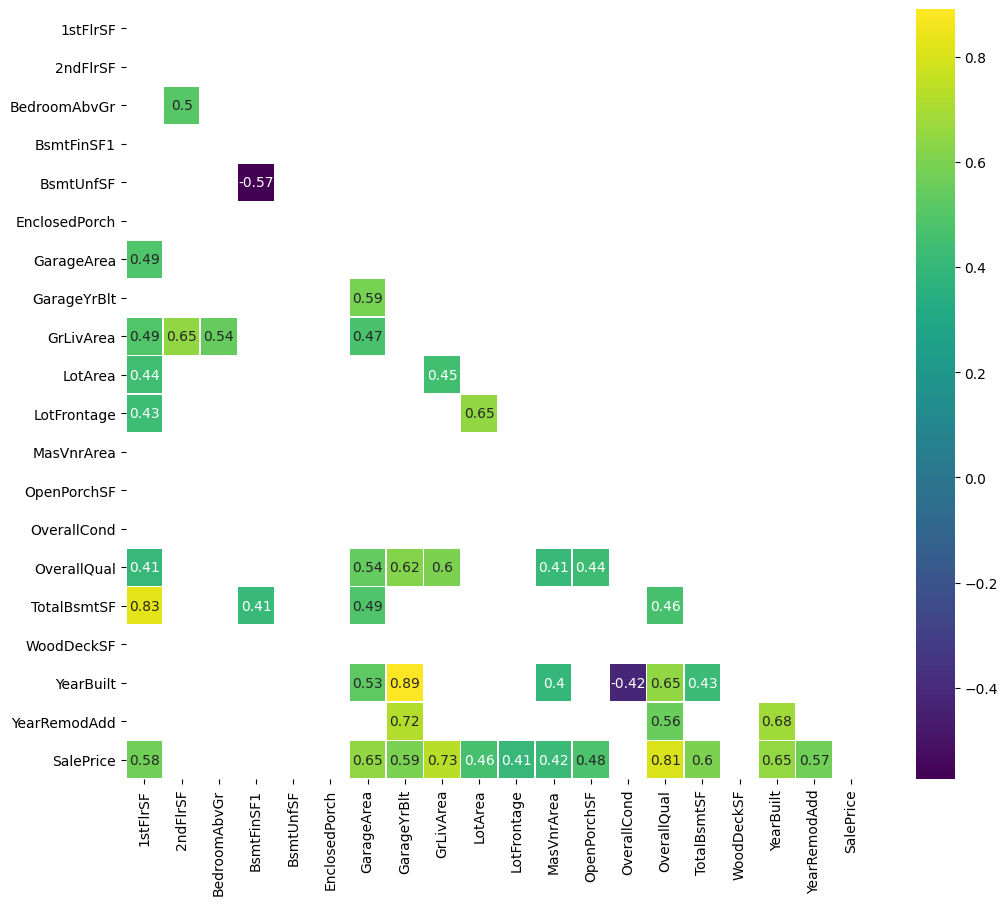



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



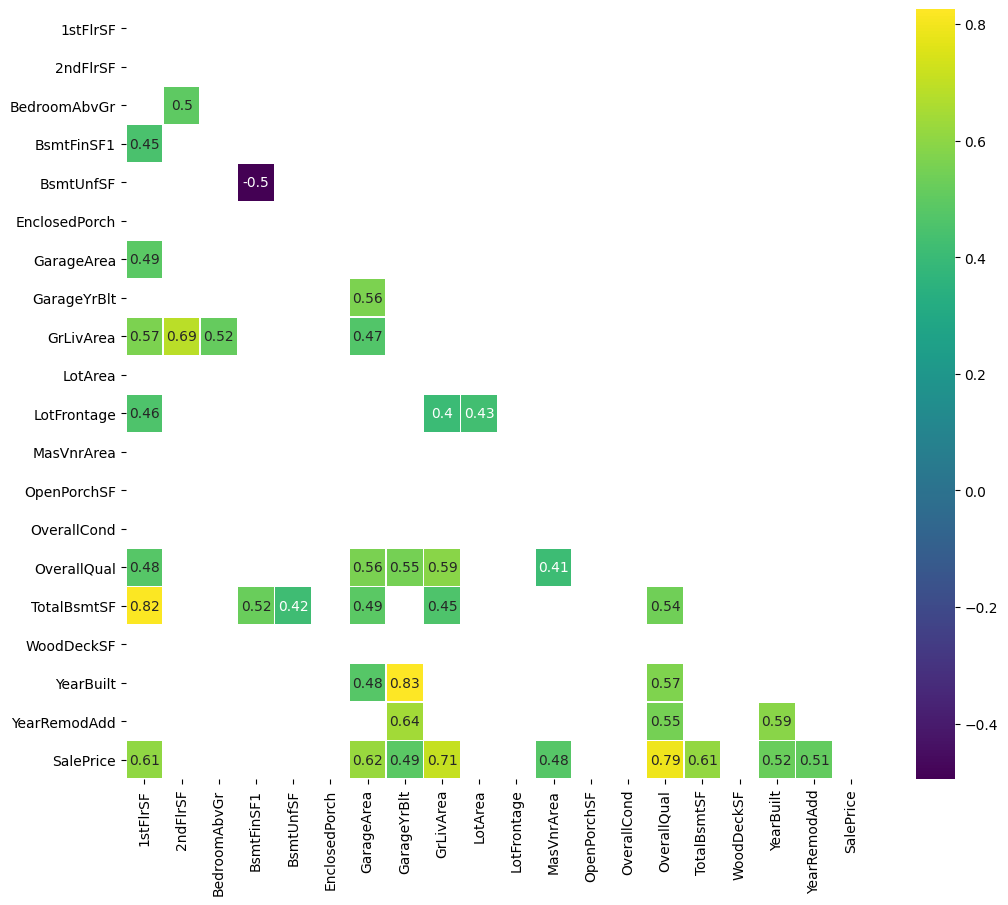



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



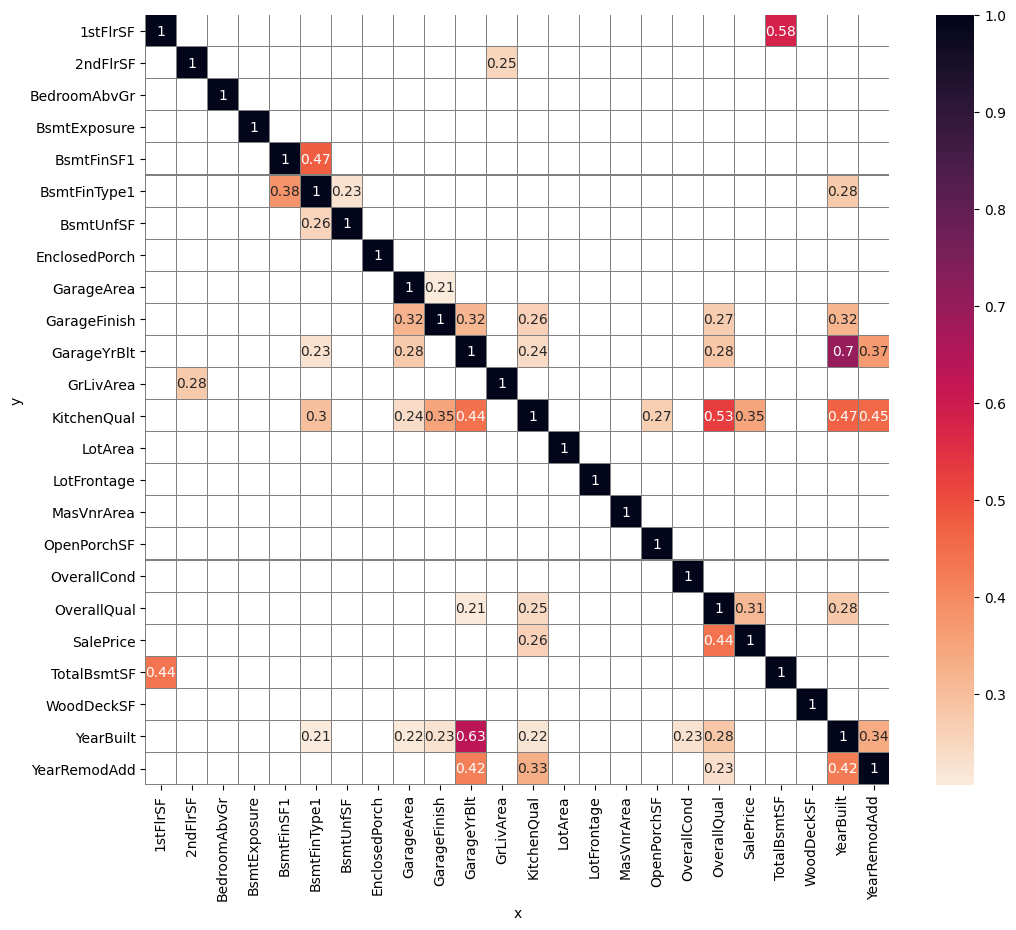

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Data Cleaning
*Assessing Missing Data Levels*

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

* Check missing data levels for the collected dataset.

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


When looking at the table that shows columns with missing data, it's important to prioritize which variables to examine and compare based on their potential impact on your analysis or model. Here are some recommendations for what might be valuable to compare:

1. EnclosedPorch (90.68% missing) & WoodDeckSF (89.38% missing):

- Why?: These two variables have a very high percentage of missing values, and both seem to relate to outdoor spaces (porches and wood decks). It’s possible that houses missing values for EnclosedPorch also lack values for WoodDeckSF if they simply don’t have a porch or a deck.
- What to Compare?: Compare rows where EnclosedPorch is missing with WoodDeckSF to see if there's a pattern where both variables are missing for the same houses.

In [12]:
df_compare_porch_deck = df[(df['EnclosedPorch'].isna()) & (df['WoodDeckSF'].isna())]
print(df_compare_porch_deck[['EnclosedPorch', 'WoodDeckSF']])

      EnclosedPorch  WoodDeckSF
1               NaN         NaN
3               NaN         NaN
5               NaN         NaN
6               NaN         NaN
7               NaN         NaN
...             ...         ...
1450            NaN         NaN
1451            NaN         NaN
1452            NaN         NaN
1456            NaN         NaN
1457            NaN         NaN

[1197 rows x 2 columns]


2. GarageFinish (11.10% missing) & GarageYrBlt (5.55% missing):

- Why?: As discussed earlier, missing values in GarageFinish might be related to whether a garage exists or not. If a garage doesn’t exist, GarageYrBlt might also be missing.
- What to Compare?: Compare rows where GarageFinish is missing with GarageArea and GarageYrBlt to see if missing GarageFinish values indicate that there is no garage.

In [13]:
df_compare_garage = df[(df['GarageFinish'].isna()) & (df['GarageYrBlt'].isna())]
print(df_compare_garage[['GarageFinish', 'GarageYrBlt', 'GarageArea']])

     GarageFinish  GarageYrBlt  GarageArea
125           NaN          NaN           0
431           NaN          NaN           0
528           NaN          NaN           0
649           NaN          NaN           0
710           NaN          NaN           0
1173          NaN          NaN           0
1323          NaN          NaN           0
1325          NaN          NaN           0


3. BsmtFinType1 (7.81% missing):

- Why?: BsmtFinType1 describes the type of finish for the basement (e.g., unfinished, partially finished). It could be related to whether the house has a basement or not.
- What to Compare?: Compare missing values in BsmtFinType1 with TotalBsmtSF (total basement square footage) to see if missing BsmtFinType1 values indicate the absence of a basement.

In [14]:
df_compare_bsmt = df[(df['BsmtFinType1'].isna()) & (df['TotalBsmtSF'] == 0)]
print(df_compare_bsmt[['BsmtFinType1', 'TotalBsmtSF']])

     BsmtFinType1  TotalBsmtSF
90            NaN            0
182           NaN            0
362           NaN            0
736           NaN            0
1049          NaN            0
1179          NaN            0


## Data Cleaning Spreadsheet Summary:



![Data cleaning](../media/data_cleaning.png)

In [15]:
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'] 




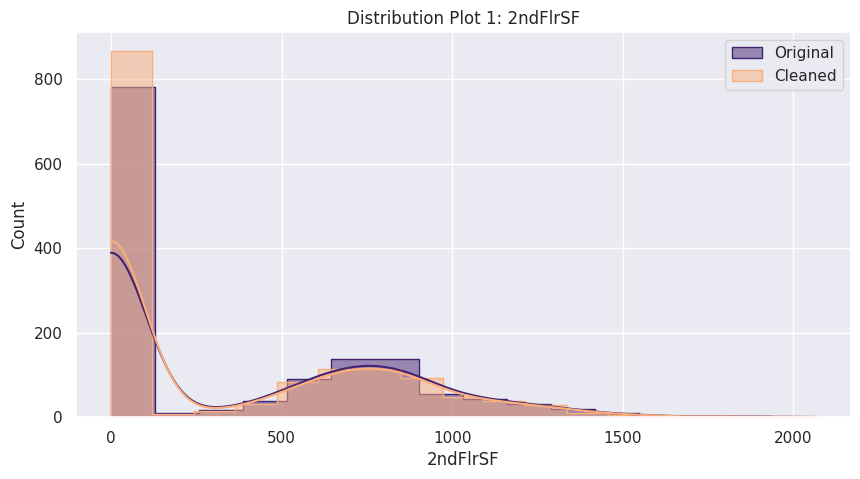

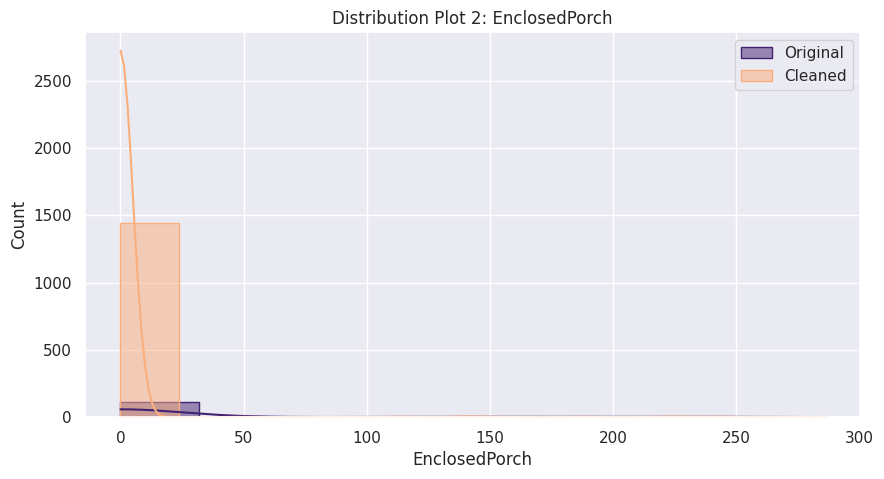

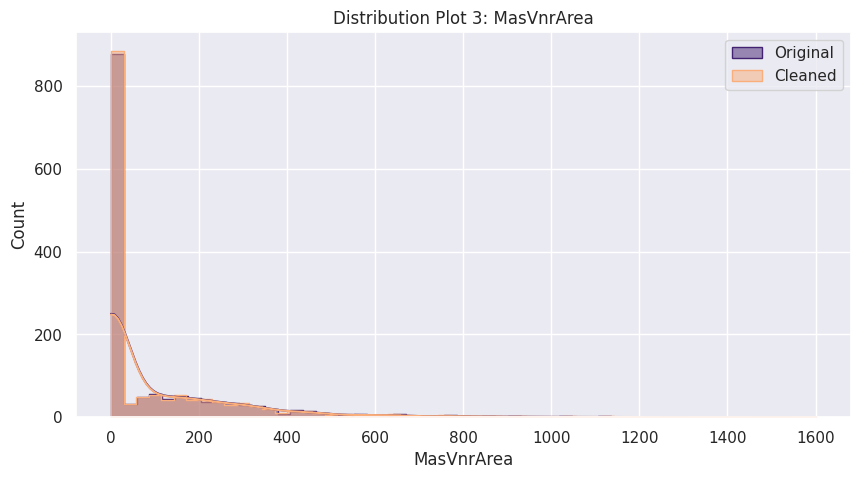

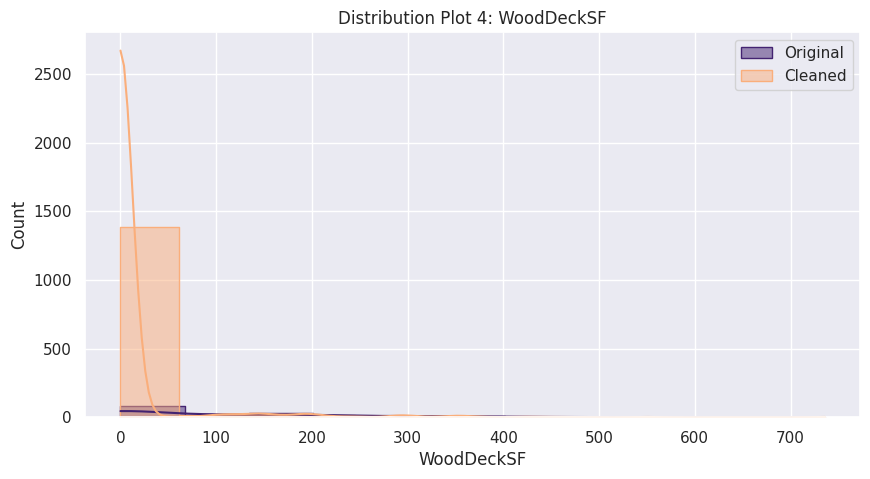

In [16]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']
variables_method

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




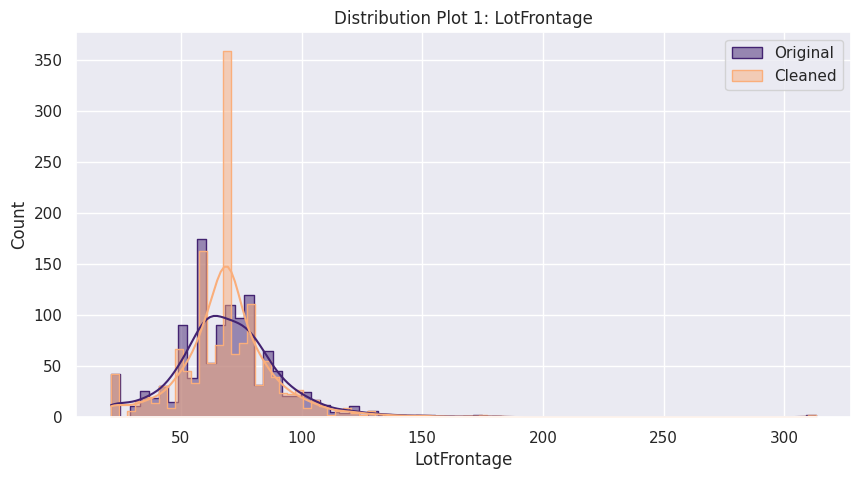

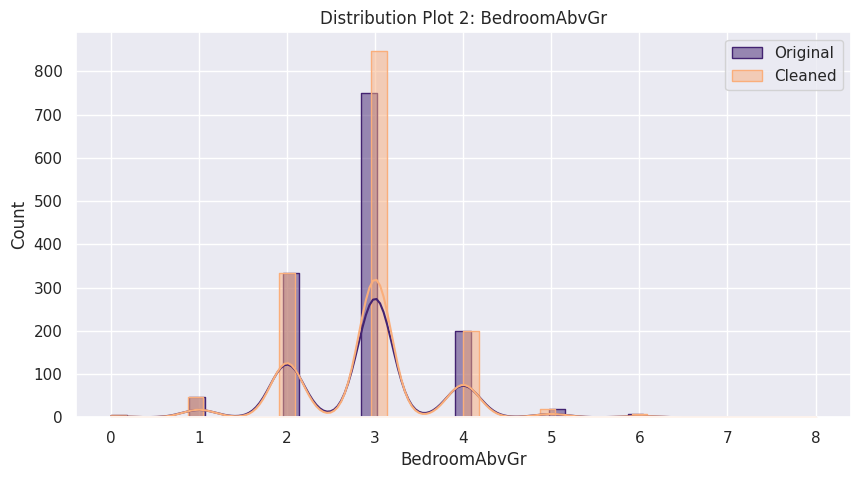

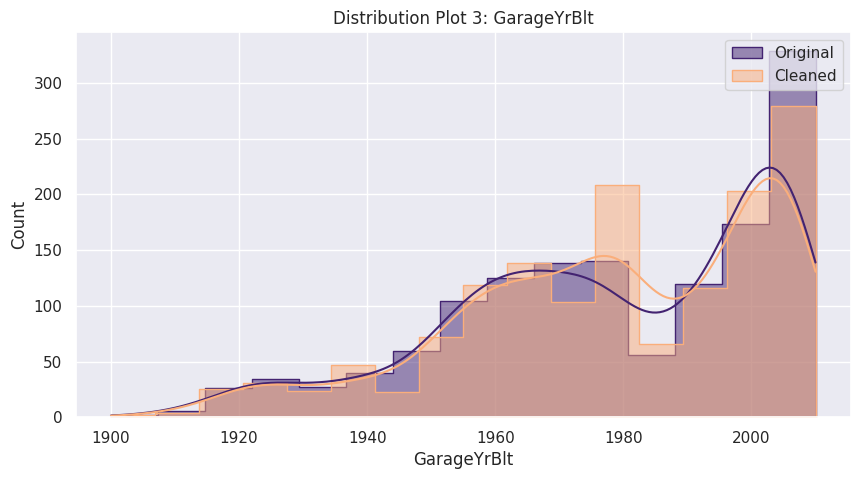

In [17]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
variables_method

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




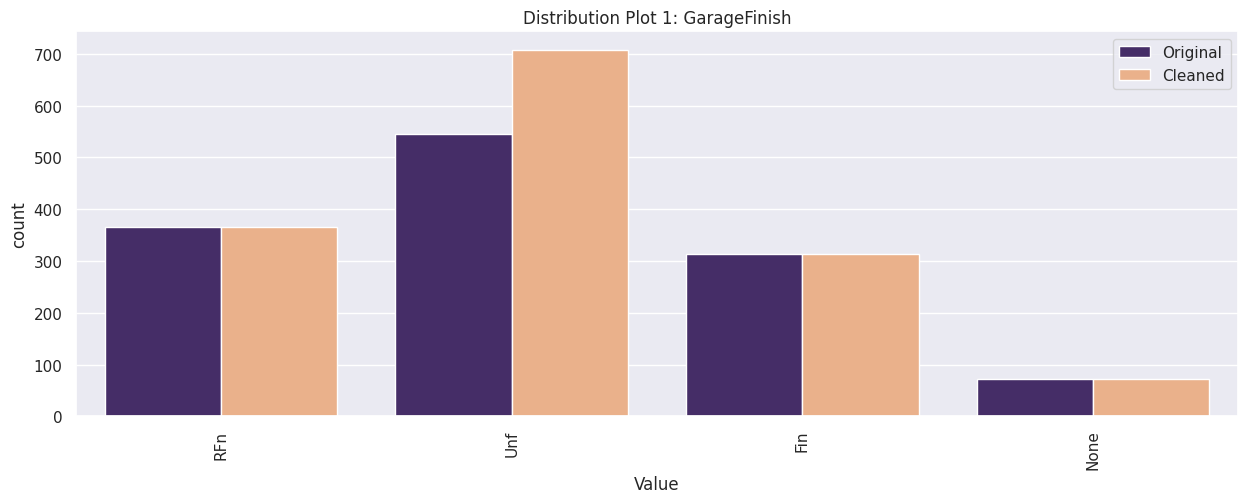

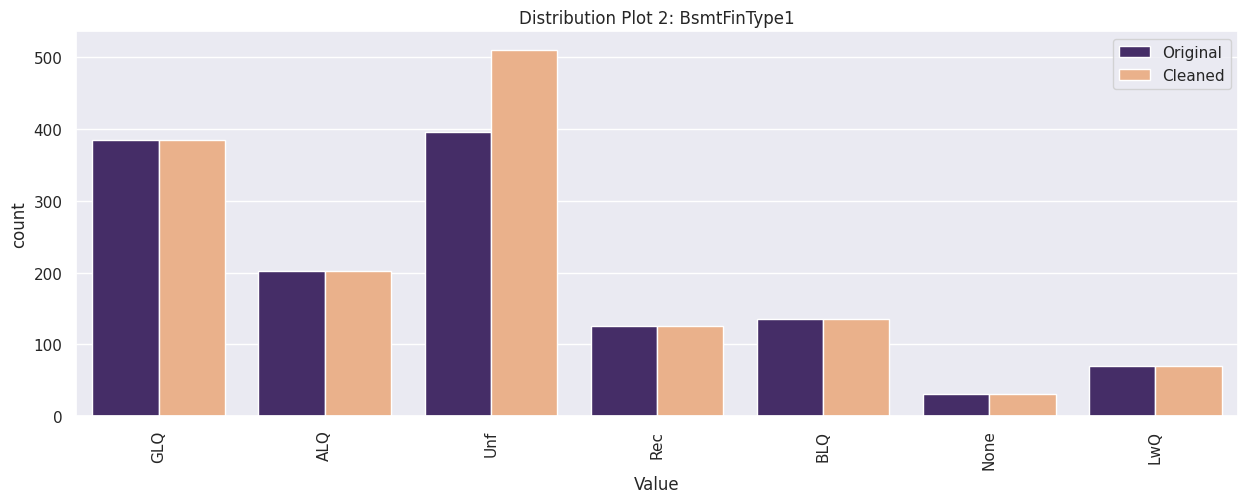

In [18]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

imputer = CategoricalImputer(imputation_method='missing',fill_value='Unf',
                             variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Split Train and Test Set

In [19]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [20]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64



___
## Applying Changes to Handle Missing Data
If we were removing rows from our dataset, we would need to reassess the data afterward, as removing rows could change the distribution of certain variables. However, since no rows are being removed in this case, we can be confident that our analysis of how the data changes after cleaning will stay consistent with our earlier assessment.

To address the missing data, we apply the following imputations:

1. Arbitrary Number Imputation:
For variables like 2ndFlrSF, EnclosedPorch, MasVnrArea, and WoodDeckSF, missing values are replaced with 0.

In [21]:
variables_method = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

2. Median Imputation:
- For variables such as LotFrontage, BedroomAbvGr, and GarageYrBlt, missing values are filled in using the median value.

In [22]:
variables_method = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

3. Categorical Imputation:
- For categorical variables like GarageFinish and BsmtFinType1, missing values are replaced with the value "Unf" (indicating unfinished).

In [23]:
variables_method = ['GarageFinish', 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

After these imputations, we reassess the dataset to confirm that there are no remaining variables with missing data:

In [24]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


In [25]:
df_missing_data = EvaluateMissingData(TestSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


___
## Push files to Repo:

In [26]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


*Train Set*

In [27]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

*Test Set*

In [28]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)